<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/Proj2_autoencoder_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tasks:
1.   import the CIFAR10 datset
2.   create 2 partitions from the dataset (train/test), making sure the data are 3x32x32
3.   apply some transformation(s)
4.   build a CNN autoencoder
     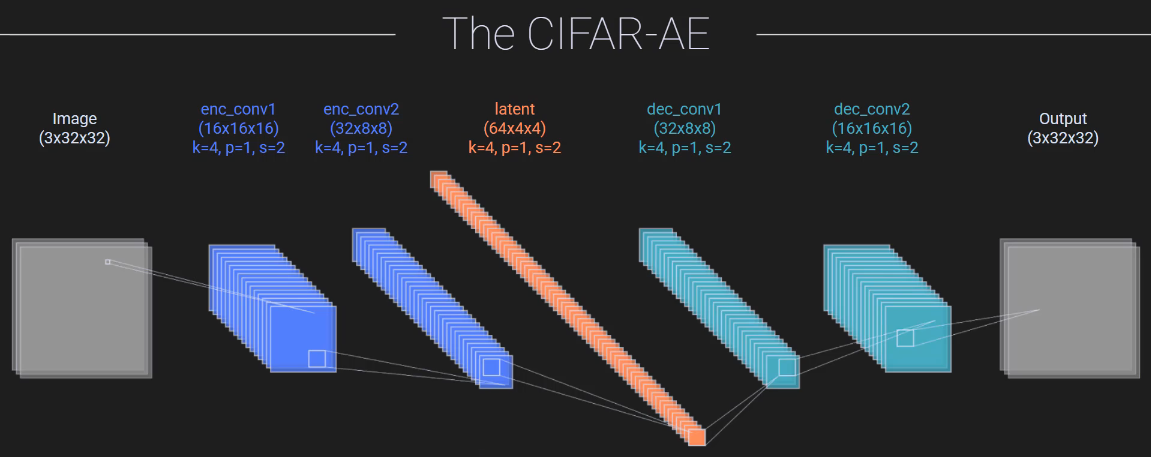
5.   plot losses vs. epochs for each partition (train & test)

In [1]:
# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [2]:
# use GPU if available：
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

In [5]:
# transformations:
transform = T.Compose([ T.ToTensor(), # convert to tensor
                        # torchvision.transforms.Normalize(mean, std, inplace=False)
                        # the first [.5,.5,.5] represents the mean values for each channel (R, G, B)
                        # the second [.5,.5,.5] represents the standard deviation values for each channel (R, G, B)
                        T.Normalize([.5,.5,.5],[.5,.5,.5]) # normalizes pixel values from [0, 1] to [-1,1] by subtracting 0.5 from each pixel value and then dividing by 0.5
                       ])

# import the CIFAR10 dataset & simultaneously apply the transformations:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform) # `train=True` -> trainset
# print(type(trainset)) # `torchvision.datasets.cifar.CIFAR10` object
print("train set:", trainset.data.shape) # (50000, 32, 32, 3)
# print(trainset.classes) # list categories -> ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) # `train=False` -> testset
print("test set:", testset.data.shape) # (10000, 32, 32, 3)

# convert to DataLoaders:
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

Files already downloaded and verified
train set: (50000, 32, 32, 3)
Files already downloaded and verified
test set: (10000, 32, 32, 3)


👆 Split data:
- train: 50000 32x32 RGB images in 10 classes (5000 images per class)
- dev:  6000
- test:  4000

In [12]:
X,y = next(iter(train_loader)) # extract a batch
print(X.shape, "\n")
print(X)
print("------------")
print(y)

torch.Size([32, 3, 32, 32]) 

tensor([[[[ 0.6627,  0.6549,  0.6706,  ..., -0.4745, -0.2941, -0.2235],
          [ 0.6627,  0.6471,  0.6627,  ..., -0.8039, -0.6941, -0.5059],
          [ 0.6549,  0.6471,  0.6627,  ..., -0.8824, -0.8588, -0.7490],
          ...,
          [ 0.4667,  0.0980, -0.7961,  ..., -0.1059,  0.3176,  0.3961],
          [ 0.4824,  0.4118, -0.5137,  ..., -0.8275, -0.3961,  0.1451],
          [ 0.3412,  0.2941, -0.2627,  ..., -0.8353, -0.8275, -0.6000]],

         [[ 0.5529,  0.5451,  0.5608,  ..., -0.8275, -0.7333, -0.5765],
          [ 0.5529,  0.5451,  0.5529,  ..., -0.8980, -0.8431, -0.7961],
          [ 0.5451,  0.5373,  0.5451,  ..., -0.8980, -0.8824, -0.8902],
          ...,
          [ 0.2000, -0.1373, -0.8510,  ..., -0.2863,  0.0588,  0.1294],
          [ 0.2235,  0.1529, -0.6078,  ..., -0.8902, -0.5529, -0.0510],
          [ 0.0745,  0.0196, -0.3804,  ..., -0.8824, -0.8745, -0.6863]],

         [[ 0.4824,  0.4745,  0.4824,  ..., -0.8118, -0.6627, -0.5059],


👆 NOTE: The transformations are actually not applied to the images directly. Instead, the transformations are ***stored*** and they are applied to the images only when we ***export the data*** or when we ***pull a little batch*** of data out of these data loaders.

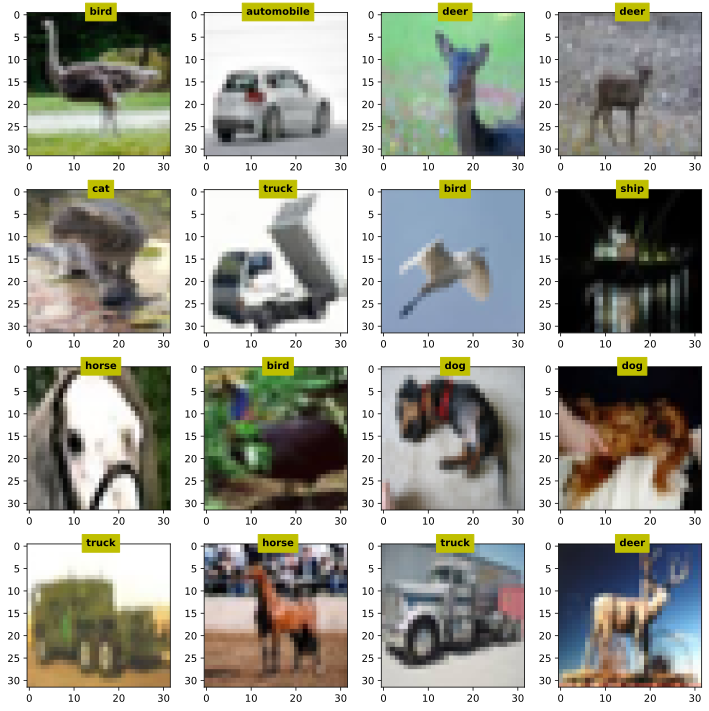

In [8]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image & transpose back to 32x32x3
  pic = X.data[i].numpy().transpose((1,2,0)) # (3, 32, 32) -> (32, 32, 3)
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # visualize
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  # ax.axis('off')

plt.tight_layout()
plt.show()

# Build a CNN autoencoder to categorize iamges:

In [13]:
# build a class for the model & create a model instance:

def makeTheAENet(printtoggle=False):

  # create a class for the model
  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      self.print = printtoggle

      # -------------- encoding --------------

      # 1st convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (32+2*1-4)/2 + 1 = 16

      # 2nd convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (16+2*1-4)/2 + 1 = 8

      # 3red convolution layer (latent layer)
      self.latent  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (8+2*1-4)/2 + 1 = 4

      # -------------- decoding --------------

      # 1st convolution layer
      self.decconv1  = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)

      # 2nd convolution layer
      self.decconv2  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

      # 3rd convolution layer (output)
      self.output  = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)

    def forward(self,x):
      if self.print: print(f'Input: {list(x.shape)}')

      # 1st encoder layer
      x = F.leaky_relu( self.encconv1(x) )
      if self.print: print(f'First encoder block: {list(x.shape)}')

      # 2nd encoder layer
      x = F.leaky_relu( self.encconv2(x) )
      if self.print: print(f'Second encoder block: {list(x.shape)}')

      # latent layer
      x = F.leaky_relu( self.latent(x) )
      if self.print: print(f'Third encoder block: {list(x.shape)}')

      # 1st decoder block
      x = F.leaky_relu( self.decconv1(x) )
      if self.print: print(f'First decoder block: {list(x.shape)}')

      # 2nd decoder block
      x = F.leaky_relu( self.decconv2(x) )
      if self.print: print(f'Second decoder block: {list(x.shape)}')

      # 3rd decoder block (output)
      x = F.leaky_relu( self.output(x) )
      if self.print: print(f'Decoder output: {list(x.shape)}')

      return x


  # create the model instance
  net = aenet(printtoggle)

  # loss function
  lossfun = nn.MSELoss() # for continous data

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [14]:
# test the model with one batch:

aenet,lossfun,optimizer = makeTheAENet(True)

X,y = next(iter(train_loader))
yHat = aenet(X)

# compute the loss
loss = lossfun(yHat,X)
print('\nloss:', loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Third encoder block: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
Second decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]

loss: tensor(0.2365, grad_fn=<MseLossBackward0>)


# Create a function to train the model:

In [16]:
# a function that trains the model

def function2trainTheAEModel(net,lossfun,optimizer):

  # send the model to the GPU
  net.to(device)

  numepochs = 20
  # initialize losses for train and test data
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
    net.train() # switch to train mode
    batchLoss = []

    # loop over train batches
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # record loss from this batch
      batchLoss.append(loss.item())
      # `loss.item()` returns the loss value for the current batch as a Python scalar (a single value as opposed to a tensor)

    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []

    for X,y in test_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)

      # record loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # record average losses across batches in each epoch
    testLoss[epochi] = np.mean(batchLoss)

  # end of epochs...

  # function output
  return trainLoss,testLoss,net

# Train the model & show the results:

In [17]:
# ~5 minutes with 15 epochs on GPU

# create a new model (comment out to re-train)
netAE,lossfun,optimizer = makeTheAENet()

trainLossAE,testLossAE,netAE = function2trainTheAEModel(netAE,lossfun,optimizer)

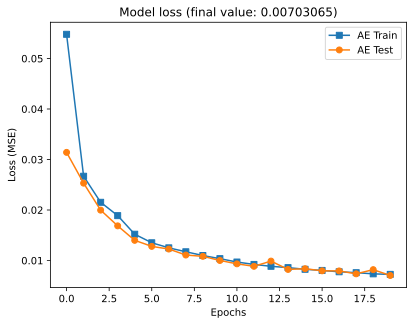

In [18]:
# show the results:

plt.plot(trainLossAE,'s-',label='AE Train')
plt.plot(testLossAE,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%testLossAE[-1])
plt.legend()

plt.show()

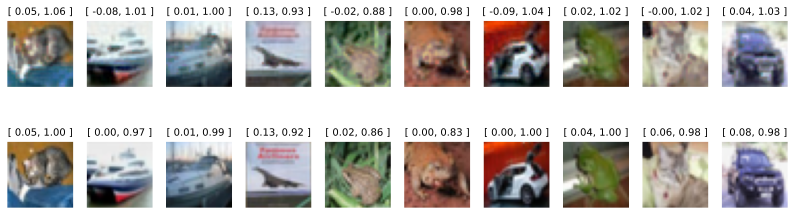

In [19]:
# show some random examples (1st: output images, 2nd row: input images)

X,y = next(iter(test_loader))

# forward pass and loss
netAE.cpu()
netAE.eval() # switch to test mode
yHat = netAE(X)

fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')

plt.show()